# Section C

In [1]:
#importing required modules and dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms

# 1) Data Preparation

In [2]:
#load the CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True)
test_data = datasets.CIFAR10(root='./data', train=False, download=True)

#extract features and labels
train_images = np.array([np.array(img) for img, _ in train_data])
train_labels = np.array([label for _, label in train_data])
test_images = np.array([np.array(img) for img, _ in test_data])
test_labels = np.array([label for _, label in test_data])

100%|██████████| 170498071/170498071 [00:03<00:00, 45988315.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#working with classes 0, 1 and 2
target_classes = [0, 1, 2]
train_indices = np.isin(train_labels, target_classes)
test_indices = np.isin(test_labels, target_classes)

#filter images and labels to keep only target classes
X_train, y_train = train_images[train_indices], train_labels[train_indices]
X_test, y_test = test_images[test_indices], test_labels[test_indices]

#stratified random split of training data into 80:20 (train:val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(f'Distribution of classes {target_classes}')
print('Training set:', np.bincount(y_train))
print('Validation set:', np.bincount(y_val))
print('Testing set:', np.bincount(y_test))

Distribution of classes [0, 1, 2]
Training set: [4000 4000 4000]
Validation set: [1000 1000 1000]
Testing set: [1000 1000 1000]


In [4]:
#transformation with normalization
transform = transforms.Compose([
    transforms.ToTensor(), #convert images to PyTorch tensors (float32)
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #normalize to [-1,1]
])

#custom dataset class
class ImageDataset:
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.tranform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.tranform(self.images[idx]), self.labels[idx]

#dataset instances for all dataset splits
train_dataset = ImageDataset(X_train, y_train, transform)
val_dataset = ImageDataset(X_val, y_val, transform)
test_dataset = ImageDataset(X_test, y_test, transform)

#dataloader instances for all dataset splits
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=True)

# 2) Visualizaiton

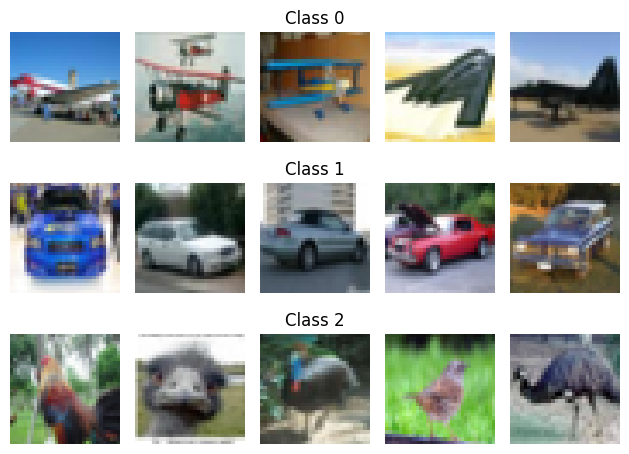

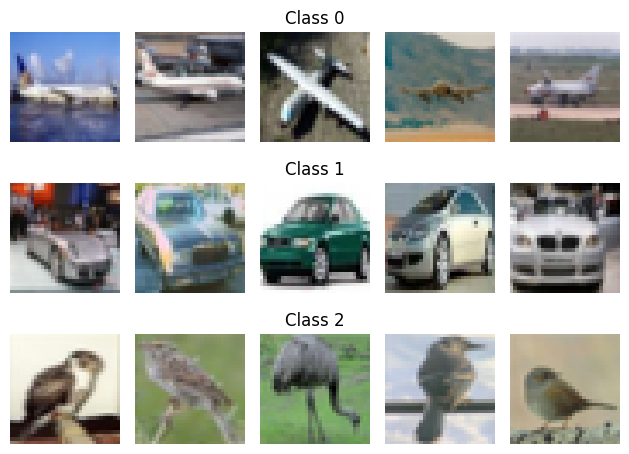

In [5]:
def visualize_samples(dataset, classes, num_images=5):
    images_per_class = {cls: [] for cls in classes}
    for image, label in dataset:
        if label in classes and len(images_per_class[label]) < num_images:
            images_per_class[label].append(image)
        if all(len(images) >= num_images for images in images_per_class.values()):
            break

    fig, axs = plt.subplots(len(classes), num_images)
    for i, (cls, images) in enumerate(images_per_class.items()):
        for j, img in enumerate(images):
            img = img.permute(1, 2, 0).numpy()
            img = img * 0.5 + 0.5
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
        axs[i, 2].set_title(f"Class {cls}")
    plt.tight_layout()
    plt.show()

#visualize samples
visualize_samples(train_dataset, target_classes)
visualize_samples(val_dataset, target_classes)

# 3) CNN Implementation

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1)
        #image size after conv1 30x30
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        #image size after maxpool1 14x14

        #second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        #image size after conv2 12x12
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        #image size after maxpool2 4x4

        #mlp layers
        self.fc1 = nn.Linear(32 * 4*4, 16)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        #convolutional layer 1 + ReLU + max pooling
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        #convolutional layer 2 + ReLU + max pooling
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)

        #flatten the tensor
        x = x.view(x.size(0), -1)
        #mlp layer 1 + ReLU
        x = self.fc1(x)
        x = nn.functional.relu(x)
        #mlp layer 2 (classification layer)
        x = self.fc2(x)
        return x

# 4) Training the model

In [7]:
model_cnn = CNN(num_classes = len(target_classes))
epochs = 15
lossFn = nn.CrossEntropyLoss()
optimizer = Adam(model_cnn.parameters(), lr=0.005)
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):
    #training phase
    model_cnn.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() #zero the gradients
        #forward pass
        outputs = model_cnn(images)
        loss = lossFn(outputs, labels)
        train_loss += loss.item()
        #backward pass and optimize
        loss.backward()
        optimizer.step()
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    #calculate average training loss and accuracy
    train_losses.append(train_loss / len(train_dataloader))
    train_acc.append(100 * correct / total)

    #validation phase
    model_cnn.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            #forward pass
            outputs = model_cnn(images)
            loss = lossFn(outputs, labels)
            val_loss += loss.item()
            #compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    #calculate average validation loss and accuracy
    val_losses.append(val_loss / len(train_dataloader))
    val_acc.append(100 * correct / total)

    #print loss and acc for train and val sets
    print(f"----- Epoch {epoch + 1}/{epochs} -----")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%")

#save the trained cnn model
torch.save(model_cnn.state_dict(), '/kaggle/working/cnn.pth')

----- Epoch 1/15 -----
Train Loss: 0.6593, Train Accuracy: 73.42%
Val Loss: 0.1397, Val Accuracy: 77.73%
----- Epoch 2/15 -----
Train Loss: 0.4412, Train Accuracy: 82.72%
Val Loss: 0.1067, Val Accuracy: 83.90%
----- Epoch 3/15 -----
Train Loss: 0.3971, Train Accuracy: 84.72%
Val Loss: 0.0952, Val Accuracy: 85.10%
----- Epoch 4/15 -----
Train Loss: 0.3550, Train Accuracy: 86.35%
Val Loss: 0.0906, Val Accuracy: 86.33%
----- Epoch 5/15 -----
Train Loss: 0.3303, Train Accuracy: 87.47%
Val Loss: 0.0969, Val Accuracy: 84.93%
----- Epoch 6/15 -----
Train Loss: 0.3142, Train Accuracy: 87.71%
Val Loss: 0.0844, Val Accuracy: 87.07%
----- Epoch 7/15 -----
Train Loss: 0.2993, Train Accuracy: 88.49%
Val Loss: 0.0977, Val Accuracy: 86.33%
----- Epoch 8/15 -----
Train Loss: 0.2825, Train Accuracy: 89.08%
Val Loss: 0.0901, Val Accuracy: 86.87%
----- Epoch 9/15 -----
Train Loss: 0.2654, Train Accuracy: 89.68%
Val Loss: 0.0886, Val Accuracy: 87.47%
----- Epoch 10/15 -----
Train Loss: 0.2421, Train Accur

# 5) Testing

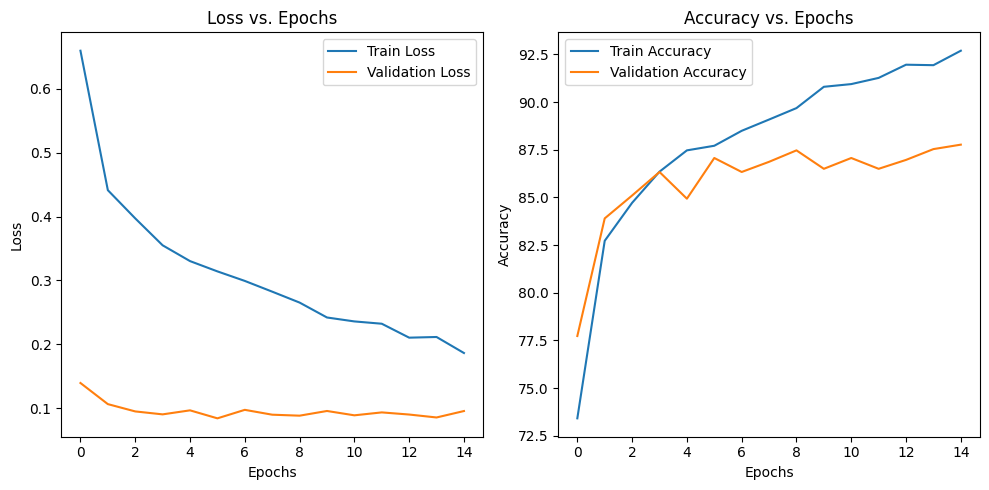

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_title('Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_acc, label='Train Accuracy')
axes[1].plot(val_acc, label='Validation Accuracy')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
#evaluate on test set
model_cnn.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test set Accuracy: {test_accuracy:.2f}%")
print(f"Test set F1-Score: {test_f1:.4f}")

Test set Accuracy: 88.47%
Test set F1-Score: 0.8842


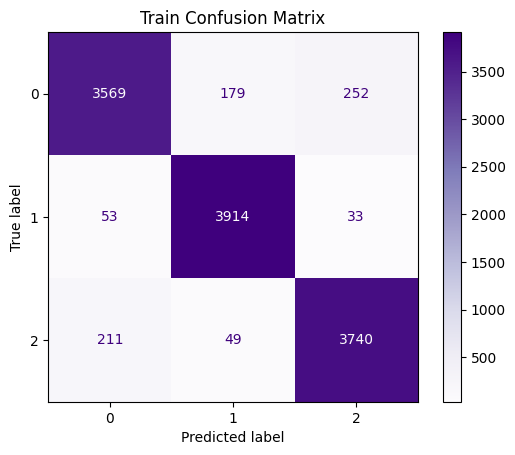

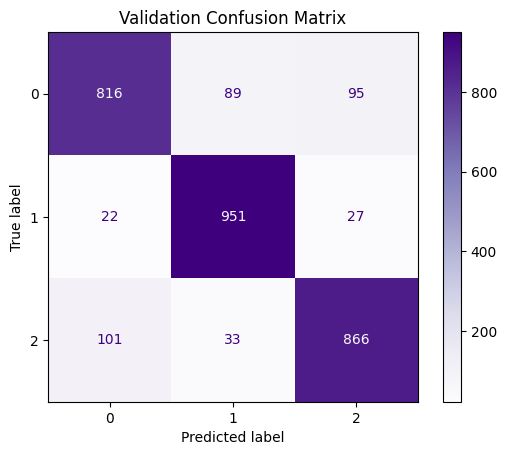

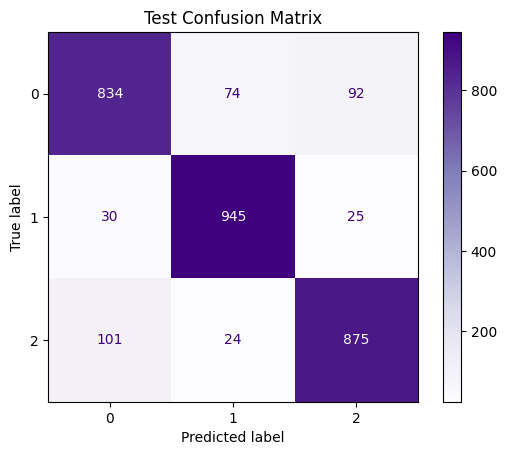

In [10]:
def plot_confusion_matrix(dataloader, title):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model_cnn(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(target_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
    disp.plot(cmap=plt.cm.Purples)
    plt.title(title)
    plt.show()

plot_confusion_matrix(train_dataloader, "Train Confusion Matrix")
plot_confusion_matrix(val_dataloader, "Validation Confusion Matrix")
plot_confusion_matrix(test_dataloader, "Test Confusion Matrix")

# 6) Training MLP

In [11]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super(MLP, self).__init__()
        #mlp layers
        self.fc1 = nn.Linear(3 * 32*32, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        #flatten the tensor
        x = x.view(x.size(0), -1)
        #mlp layer 1 + ReLU
        x = self.fc1(x)
        x = nn.functional.relu(x)
        #mlp layer 2 (classification layer)
        x = self.fc2(x)
        return x

In [12]:
model_mlp = MLP(num_classes = len(target_classes))
epochs = 15
lossFn = nn.CrossEntropyLoss()
optimizer = Adam(model_mlp.parameters(), lr=0.005)
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(epochs):
    #training phase
    model_mlp.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_dataloader:
        optimizer.zero_grad() #zero the gradients
        #forward pass
        outputs = model_mlp(images)
        loss = lossFn(outputs, labels)
        train_loss += loss.item()
        #backward pass and optimize
        loss.backward()
        optimizer.step()
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    #calculate average training loss and accuracy
    train_losses.append(train_loss / len(train_dataloader))
    train_acc.append(100 * correct / total)

    #validation phase
    model_mlp.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            #forward pass
            outputs = model_mlp(images)
            loss = lossFn(outputs, labels)
            val_loss += loss.item()
            #compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    #calculate average validation loss and accuracy
    val_losses.append(val_loss / len(train_dataloader))
    val_acc.append(100 * correct / total)

    #print loss and acc for train and val sets
    print(f"----- Epoch {epoch + 1}/{epochs} -----")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%")

#save the trained mlp model
torch.save(model_mlp.state_dict(), '/kaggle/working/mlp.pth')

----- Epoch 1/15 -----
Train Loss: 0.7516, Train Accuracy: 70.47%
Val Loss: 0.1885, Val Accuracy: 71.07%
----- Epoch 2/15 -----
Train Loss: 0.6152, Train Accuracy: 75.95%
Val Loss: 0.1783, Val Accuracy: 73.00%
----- Epoch 3/15 -----
Train Loss: 0.5884, Train Accuracy: 77.40%
Val Loss: 0.1640, Val Accuracy: 74.77%
----- Epoch 4/15 -----
Train Loss: 0.5556, Train Accuracy: 78.57%
Val Loss: 0.1733, Val Accuracy: 74.47%
----- Epoch 5/15 -----
Train Loss: 0.5286, Train Accuracy: 79.61%
Val Loss: 0.1743, Val Accuracy: 75.93%
----- Epoch 6/15 -----
Train Loss: 0.5056, Train Accuracy: 81.03%
Val Loss: 0.1725, Val Accuracy: 75.33%
----- Epoch 7/15 -----
Train Loss: 0.4689, Train Accuracy: 82.75%
Val Loss: 0.1774, Val Accuracy: 75.63%
----- Epoch 8/15 -----
Train Loss: 0.4487, Train Accuracy: 83.40%
Val Loss: 0.1736, Val Accuracy: 77.37%
----- Epoch 9/15 -----
Train Loss: 0.4392, Train Accuracy: 83.98%
Val Loss: 0.2093, Val Accuracy: 76.30%
----- Epoch 10/15 -----
Train Loss: 0.4233, Train Accur

# 7) Infer MLP

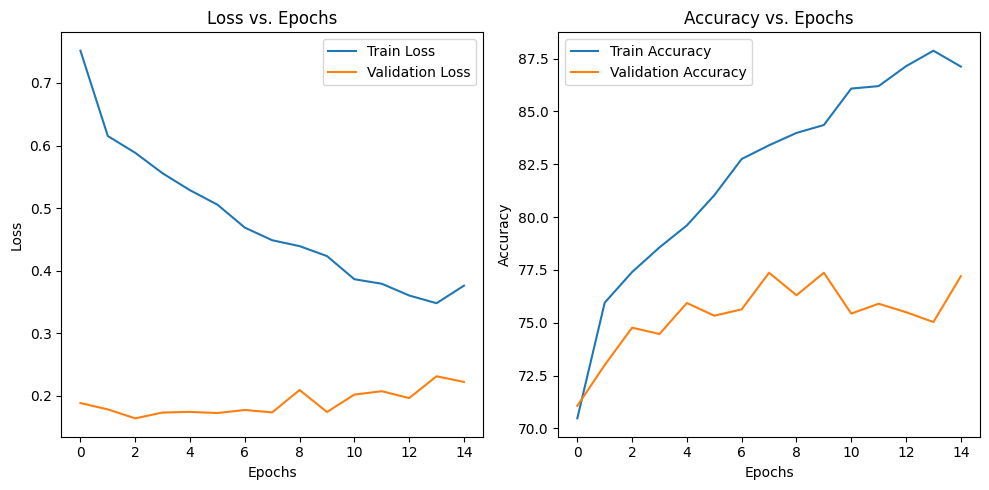

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_title('Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_acc, label='Train Accuracy')
axes[1].plot(val_acc, label='Validation Accuracy')
axes[1].set_title('Accuracy vs. Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [14]:
#evaluate on test set
model_mlp.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model_mlp(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test set Accuracy: {test_accuracy:.2f}%")
print(f"Test set F1-Score: {test_f1:.4f}")

Test set Accuracy: 78.97%
Test set F1-Score: 0.7886


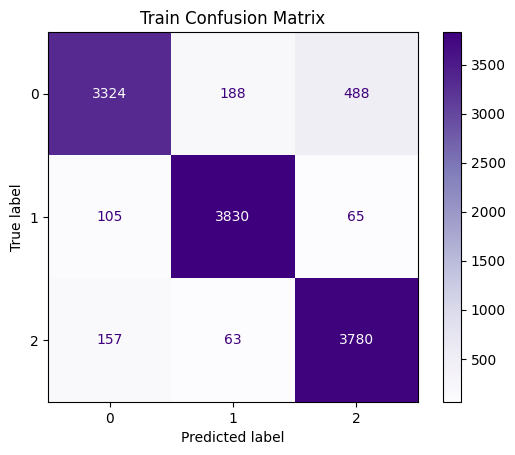

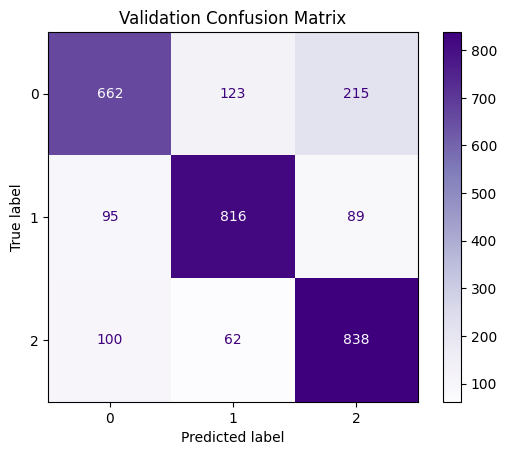

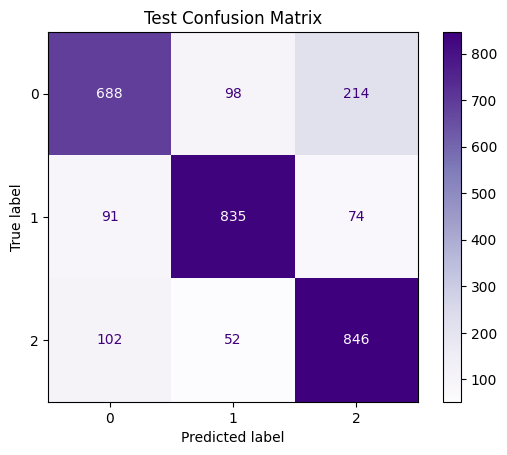

In [15]:
def plot_confusion_matrix(dataloader, title):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model_mlp(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(target_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
    disp.plot(cmap=plt.cm.Purples)
    plt.title(title)
    plt.show()

plot_confusion_matrix(train_dataloader, "Train Confusion Matrix")
plot_confusion_matrix(val_dataloader, "Validation Confusion Matrix")
plot_confusion_matrix(test_dataloader, "Test Confusion Matrix")

# Validate Models

In [16]:
model_cnn = CNN(num_classes = len(target_classes))  #instantiate the model
model_cnn.load_state_dict(torch.load('/kaggle/working/cnn.pth')) #load model

#evaluate on test set
model_cnn.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test set Accuracy: {test_accuracy:.2f}%")
print(f"Test set F1-Score: {test_f1:.4f}")

/tmp/ipykernel_30/550971023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('/kaggle/working/cnn.pth')) #load model


Test set Accuracy: 88.47%
Test set F1-Score: 0.8842


In [17]:
model_mlp = MLP(num_classes = len(target_classes))  #instantiate the model
model_mlp.load_state_dict(torch.load('/kaggle/working/mlp.pth')) #load model

#evaluate on test set
model_mlp.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model_mlp(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
test_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test set Accuracy: {test_accuracy:.2f}%")
print(f"Test set F1-Score: {test_f1:.4f}")

/tmp/ipykernel_30/1426446152.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp.load_state_dict(torch.load('/kaggle/working/mlp.pth')) #load model


Test set Accuracy: 78.97%
Test set F1-Score: 0.7886
